## About Data 

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## **IMPORTING LIBRARIES**

In [3]:
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## **DATA COLLECTION AND READING**

In [5]:
df=pd.read_csv('Fraud.csv')
df_new=pd.read_csv( 'Fraud.csv',nrows=3000000)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(df).style.background_gradient(cmap='YlOrRd')

,dtypes,missing#,missing%,uniques,count,min,max,mean
step,int64,0,0.000000,743,6362620,1.000000,743.000000,243.397246
type,object,0,0.000000,5,6362620,nan,nan,nan
amount,float64,0,0.000000,5316900,6362620,0.000000,92445516.640000,179861.903549
nameOrig,object,0,0.000000,6353307,6362620,nan,nan,nan
oldbalanceOrg,float64,0,0.000000,1845844,6362620,0.000000,59585040.370000,833883.104074
newbalanceOrig,float64,0,0.000000,2682586,6362620,0.000000,49585040.370000,855113.668579
nameDest,object,0,0.000000,2722362,6362620,nan,nan,nan
oldbalanceDest,float64,0,0.000000,3614697,6362620,0.000000,356015889.350000,1100701.666520
newbalanceDest,float64,0,0.000000,3555499,6362620,0.000000,356179278.920000,1224996.398202
isFraud,int64,0,0.000000,2,6362620,0.000000,1.000000,0.001291


## findings

1. There are 6362620 rows and 11 columns in the dataset.
2. There are no null values in the dataset.
3. There are 6 types of transactions in the dataset - CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER and CASH-IN.
4. The dataset contains 8213 fraudulent transactions and 6354407 non-fraudulent transactions.
5. The dataset contains 0 flagged fraudulent transactions.
6. The maximum transaction amount is 25691.16 and the minimum transaction amount is 0.0.



In [8]:
# NO null values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
# No Duplicates
df.duplicated().sum()

0

In [10]:
# we will drop this kind of imbalance feature
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

<Axes: >

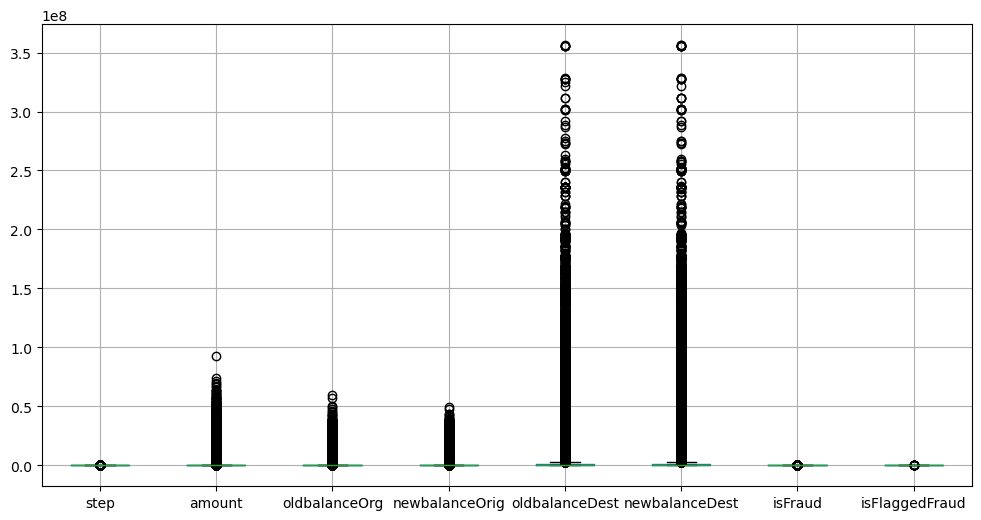

In [11]:
df.boxplot(figsize=(12,6))

In [ ]:
import pandas as pd

# Select only numeric columns
numeric_columns = df.select_dtypes(include=['int64','float64'])

# Calculate quantiles for numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Function to detect outliers and calculate their percentage
def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")


Column: step, Percentage of outliers: 1.61%
Column: amount, Percentage of outliers: 5.31%
Column: oldbalanceOrg, Percentage of outliers: 17.49%
Column: newbalanceOrig, Percentage of outliers: 16.56%
Column: oldbalanceDest, Percentage of outliers: 12.36%
Column: newbalanceDest, Percentage of outliers: 11.61%
Column: isFraud, Percentage of outliers: 0.13%
Column: isFlaggedFraud, Percentage of outliers: 0.00%


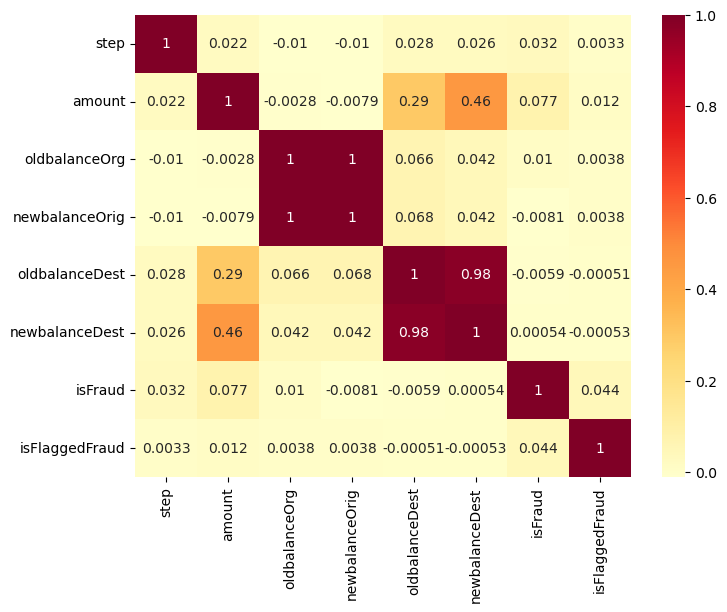

In [13]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()


In [14]:
# due high Multicollinearity we will drop oldbalance data beacuse instead of that columns we can make use of newbalance data
df.drop(columns=['oldbalanceDest', 'oldbalanceOrg'], inplace=True)


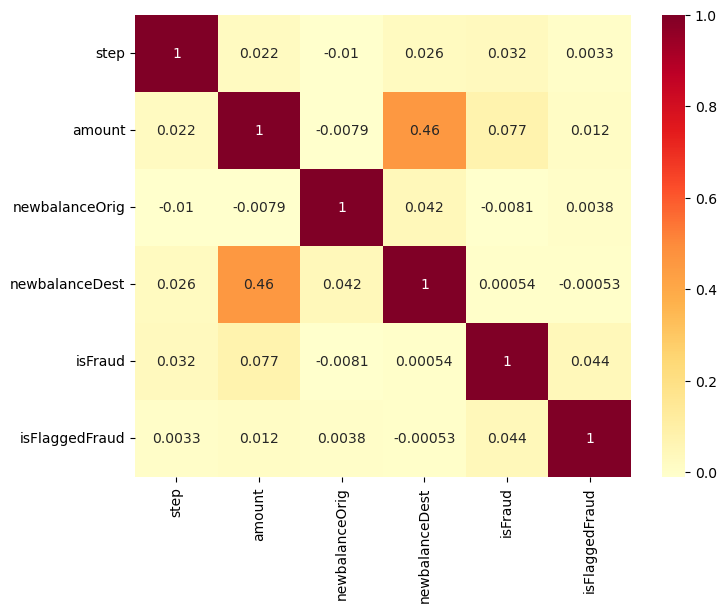

In [15]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.show()


In [45]:
# Distribution of Transaction Types
sns.countplot(data=df, x='type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Distribution of Transaction Types')

Text(0.5, 1.0, 'Distribution of Transaction Types')

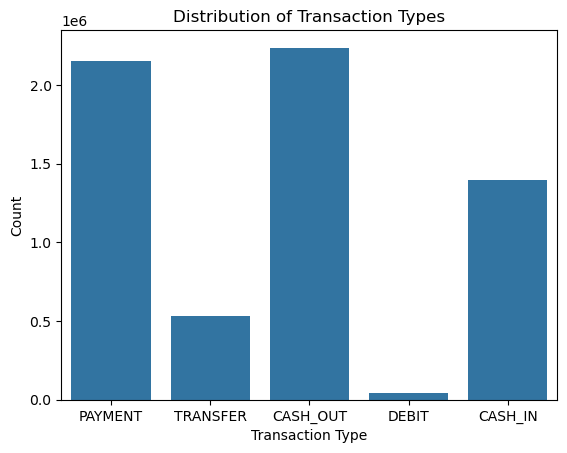

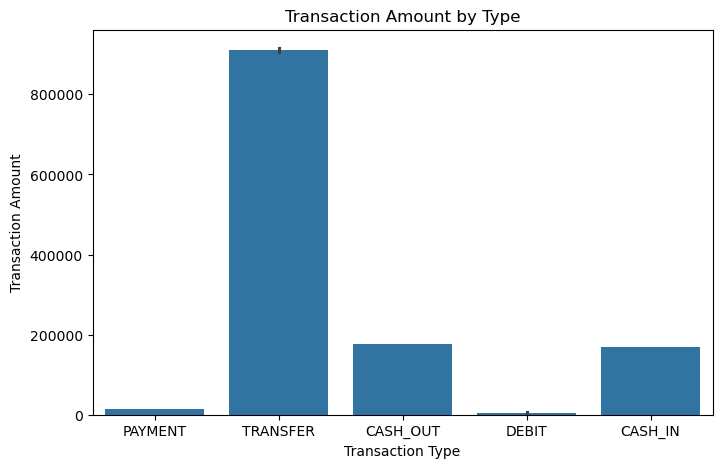

In [17]:
# the highest transaction amount is transfered by TRANSFER type
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='type', y='amount')
plt.xticks(rotation=0)  
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount by Type')
plt.show()

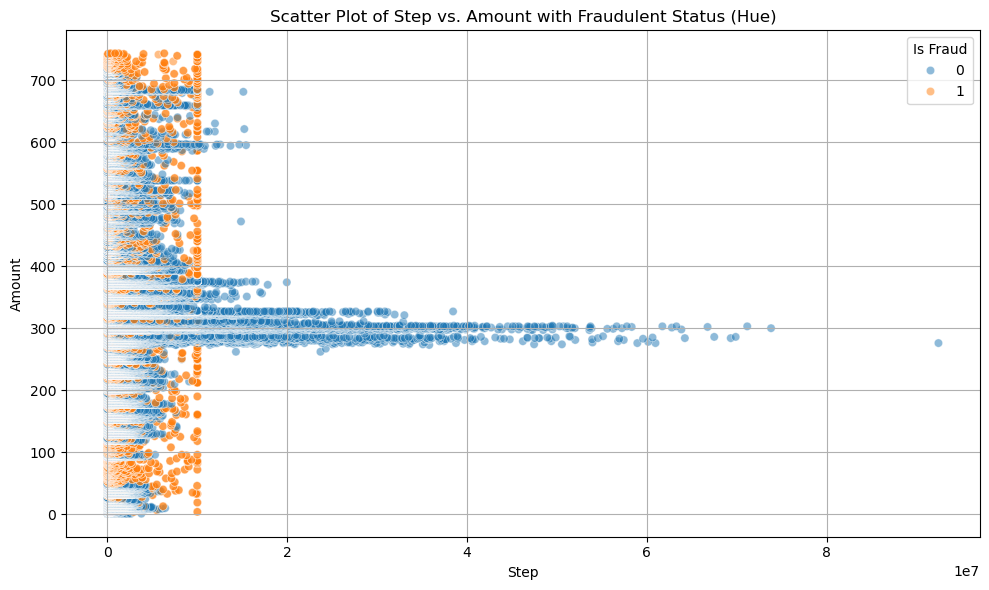

In [18]:
# There are total 744 steps, In this case 1 step is 1 hour of time
# Fraud transaction happend within 1 or 2 steps, means in less time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='amount', y='step', hue='isFraud', alpha=0.5)
plt.xlabel('Step')
plt.ylabel('Amount')
plt.title('Scatter Plot of Step vs. Amount with Fraudulent Status (Hue)')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Is Fraud')
plt.show()

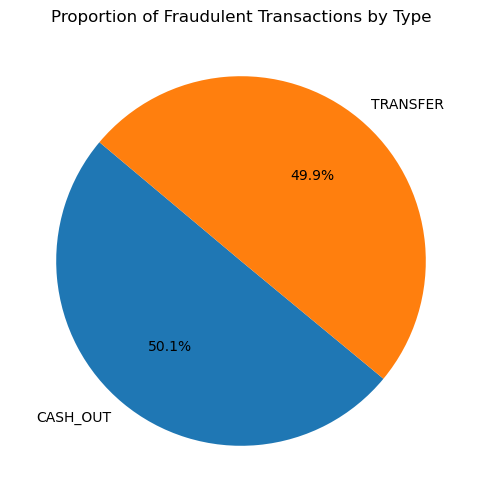

In [19]:
# Fraud transaction is happend by two types only 'TRANSFER' and 'CASH_OUT'
fraud_proportion = df[df['isFraud'] == 1]['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(fraud_proportion, labels=fraud_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Fraudulent Transactions by Type')
plt.show()

## **USING df_new**

* here we will use df_new because system was unable to handle whole data
* From df_new we will drop 'isFlaggedFraud' because it was highly imbalanced
* we have to drop highly correlated columns i.e 'oldbalanceOrg' and 'oldbalanceDest'.

In [20]:
df_new.drop(['oldbalanceOrg','oldbalanceDest','isFlaggedFraud'],axis=1,inplace=True)

In [21]:
# Treating ouliers
df_new.boxplot(figsize=(12,6))

<Axes: >

In [22]:
numeric_columns = df_new.select_dtypes(include=['int64','float64'])

# Calculate quantiles for numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# The rest of your code to detect outliers should remain the same
def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df_new[(df_new[column] < lower_bound) | (df_new[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df_new)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: amount, Percentage of outliers: 5.04%
Column: newbalanceOrig, Percentage of outliers: 16.40%
Column: newbalanceDest, Percentage of outliers: 11.06%
Column: isFraud, Percentage of outliers: 0.09%


In [23]:
# removing outliers
def remove_outlier(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    return lower_range,upper_range

In [24]:
low_leadtime,high_leadtime=remove_outlier(df_new['newbalanceOrig'])
df_new['newbalanceOrig']=np.where(df_new['newbalanceOrig']>high_leadtime,high_leadtime,df_new['newbalanceOrig'])
df_new['newbalanceOrig']=np.where(df_new['newbalanceOrig']<low_leadtime,low_leadtime,df_new['newbalanceOrig'])

In [25]:

low_leadtime,high_leadtime=remove_outlier(df_new['newbalanceDest'])
df_new['newbalanceDest']=np.where(df_new['newbalanceDest']>high_leadtime,high_leadtime,df_new['newbalanceDest'])
df_new['newbalanceDest']=np.where(df_new['newbalanceDest']<low_leadtime,low_leadtime,df_new['newbalanceDest'])

## **ENCODING**

In [26]:
# encoding 'type' column
df_new = pd.get_dummies(df_new, columns=['type'], prefix=['type'])
df_new.shape

(3000000, 12)

In [27]:
df_new.head()

,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,160296.36,M1979787155,0.0,0,False,False,False,True,False
1,1,1864.28,C1666544295,19384.72,M2044282225,0.0,0,False,False,False,True,False
2,1,181.00,C1305486145,0.00,C553264065,0.0,1,False,False,False,False,True
3,1,181.00,C840083671,0.00,C38997010,0.0,1,False,True,False,False,False
4,1,11668.14,C2048537720,29885.86,M1230701703,0.0,0,False,False,False,True,False


In [28]:
# encoding 'nameOrig' and 'nameDest'
le=LabelEncoder()
df_new['nameOrig']=le.fit_transform(df_new['nameOrig'])
df_new['nameDest']=le.fit_transform(df_new['nameDest'])

In [29]:
df_new.head(5)

,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,358086,160296.36,780575,0.0,0,False,False,False,True,False
1,1,1864.28,1033293,19384.72,814368,0.0,0,False,False,False,True,False
2,1,181.00,473430,0.00,208115,0.0,1,False,False,False,False,True
3,1,181.00,2749909,0.00,185468,0.0,1,False,True,False,False,False
4,1,11668.14,1625449,29885.86,390711,0.0,0,False,False,False,True,False


In [30]:
# Highly imbalanced
df_new['isFraud'].value_counts()

isFraud
0    2997381
1       2619
Name: count, dtype: int64

## **SPLITTING**|

In [31]:
x=df_new.drop(['isFraud'],axis=1)
y=df_new['isFraud']

### **SMOTING**

In [32]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
x, y = smote.fit_resample(x, y)

In [33]:
y.value_counts()

isFraud
0    2997381
1    2997381
Name: count, dtype: int64

### **TRAIN TEST SPLITTING**

In [34]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=142)

In [35]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(4496071, 11)
(1498691, 11)
(4496071,)
(1498691,)


In [36]:
#scaling the data
sc=StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtest_sc=sc.transform(xtest)

In [37]:
# accuracy funtion
def acc_report(actual,predicted):
    acc_score=accuracy_score(actual,predicted)
    class_rep=classification_report(actual,predicted)
    print('the accuracy of tha model is ',acc_score)
    print(class_rep)

## **LogisticRegression**

In [38]:
# Initialize and train the Logistic Regression model
lgr = LogisticRegression(max_iter=500)
lgr.fit(xtrain_sc, ytrain)

LogisticRegression(max_iter=500)

In [39]:
ypred_train_lgr=lgr.predict(xtrain_sc)
ypred_test_lgr=lgr.predict(xtest_sc)

In [40]:
acc_report(ytrain,ypred_train_lgr)
acc_report(ytest,ypred_test_lgr)

the accuracy of tha model is  0.8426826444689152
              precision    recall  f1-score   support

           0       0.90      0.77      0.83   2247761
           1       0.80      0.92      0.85   2248310

    accuracy                           0.84   4496071
   macro avg       0.85      0.84      0.84   4496071
weighted avg       0.85      0.84      0.84   4496071

the accuracy of tha model is  0.8426500192501323
              precision    recall  f1-score   support

           0       0.90      0.77      0.83    749620
           1       0.80      0.92      0.85    749071

    accuracy                           0.84   1498691
   macro avg       0.85      0.84      0.84   1498691
weighted avg       0.85      0.84      0.84   1498691



In [41]:
rand_model=RandomForestClassifier()
rand_model.fit(xtrain_sc,ytrain)

RandomForestClassifier()

In [43]:
ypred_train_rand=rand_model.predict(xtrain_sc)
ypred_test_rand=rand_model.predict(xtest_sc)

In [44]:
acc_report(ytrain,ypred_train_rand)
acc_report(ytest,ypred_test_rand)

the accuracy of tha model is  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2247761
           1       1.00      1.00      1.00   2248310

    accuracy                           1.00   4496071
   macro avg       1.00      1.00      1.00   4496071
weighted avg       1.00      1.00      1.00   4496071

the accuracy of tha model is  0.9991225676273494
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    749620
           1       1.00      1.00      1.00    749071

    accuracy                           1.00   1498691
   macro avg       1.00      1.00      1.00   1498691
weighted avg       1.00      1.00      1.00   1498691



## **Identifying important features**

In [42]:
# coefficients indicate the strength and direction of the relationship between each feature and the target variable
feature_coefficients = lgr.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': xtrain.columns,
    'Coefficient': feature_coefficients
})

feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

print(feature_importance_df)

           Feature  Coefficient  Absolute_Coefficient
7    type_CASH_OUT     7.174176              7.174176
10   type_TRANSFER     6.966925              6.966925
3   newbalanceOrig    -4.688415              4.688415
1           amount     3.383848              3.383848
9     type_PAYMENT    -2.859389              2.859389
5   newbalanceDest    -0.931039              0.931039
4         nameDest     0.235792              0.235792
8       type_DEBIT    -0.228178              0.228178
0             step    -0.184564              0.184564
6     type_CASH_IN    -0.142692              0.142692
2         nameOrig     0.009554              0.009554


           Feature  Importance
5   newbalanceDest    0.167938
1           amount    0.158502
0             step    0.137892
10   type_TRANSFER    0.126049
3   newbalanceOrig    0.124137
4         nameDest    0.108761
2         nameOrig    0.055510
7    type_CASH_OUT    0.053850
9     type_PAYMENT    0.042101
6     type_CASH_IN    0.024755
8       type_DEBIT    0.000505


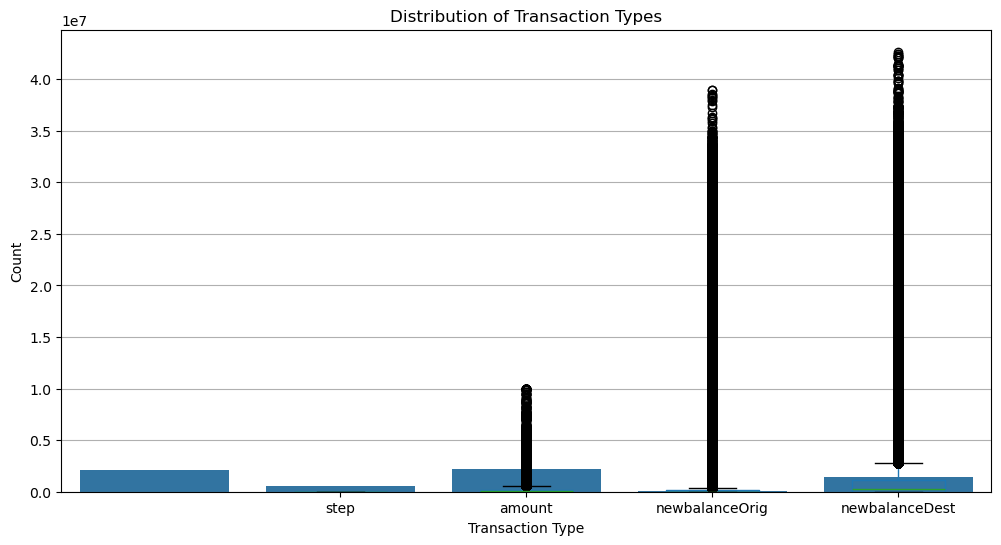

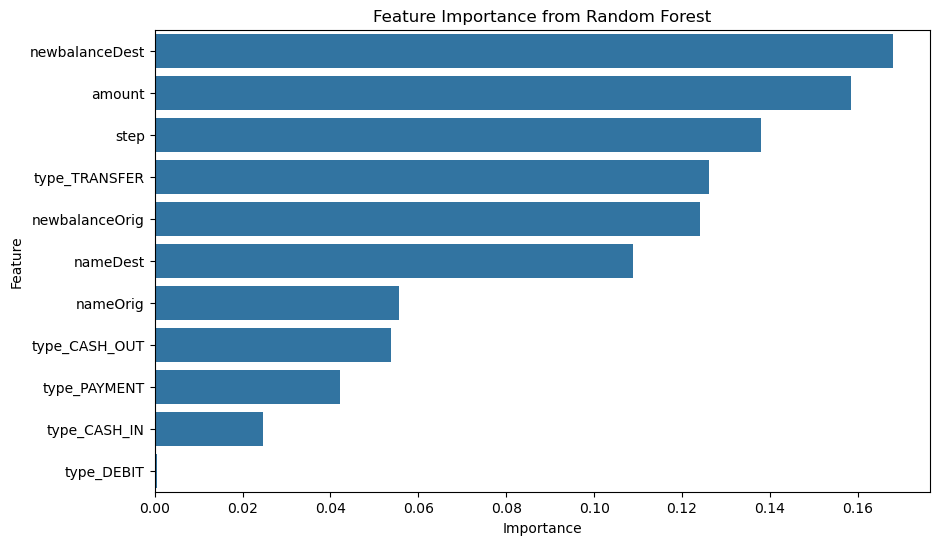

In [46]:
## identifying from random forest
importances = rand_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({
    'Feature': xtrain.columns,
    'Importance': importances
})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
print(feature_importance_df_rf)
# Plotting feature importance from Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance from Random Forest')
plt.show()


## Both the models have their own pros and cons for example:

> Logistic regression take less time to train the model but it is not as accurate as RandomForestClassifier.
> RandomForestClassifier takes more time to train the model but it is more accurate than Logistic regression.
